## **#1 Import Libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report

import numpy as np

In [ ]:
# pandas data frame options tweaking.
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


## **#2 Load Dataset**

In [ ]:
dataset_url = 'https://raw.githubusercontent.com/M-Zouman/GP2/main/Datasets/Laboratory%20Based/Italian%20Society%20of%20Medical%20Radiology%20Dataset/Metadata/Dataset(B).csv'
data = pd.read_csv(dataset_url, encoding = "utf-8")

## **#3 Preprocessing**

In [ ]:
# Changing the target variable labels. COVID-19 == 1, Flu == 0.
data.loc[data['Decision label'] == "COVID-19", "Decision label"] = 1
data.loc[data['Decision label'] == "Flu", 'Decision label'] = 0 

In [ ]:
# Target variable class distribution of [orginal dataset].
print(data.groupby('Decision label').size())

Decision label
0    62
1    68
dtype: int64


In [ ]:
# Replace cells that have '*' value with NaN. 
for column in data.columns:
  data.loc[data[column] == "*", column] = np.nan

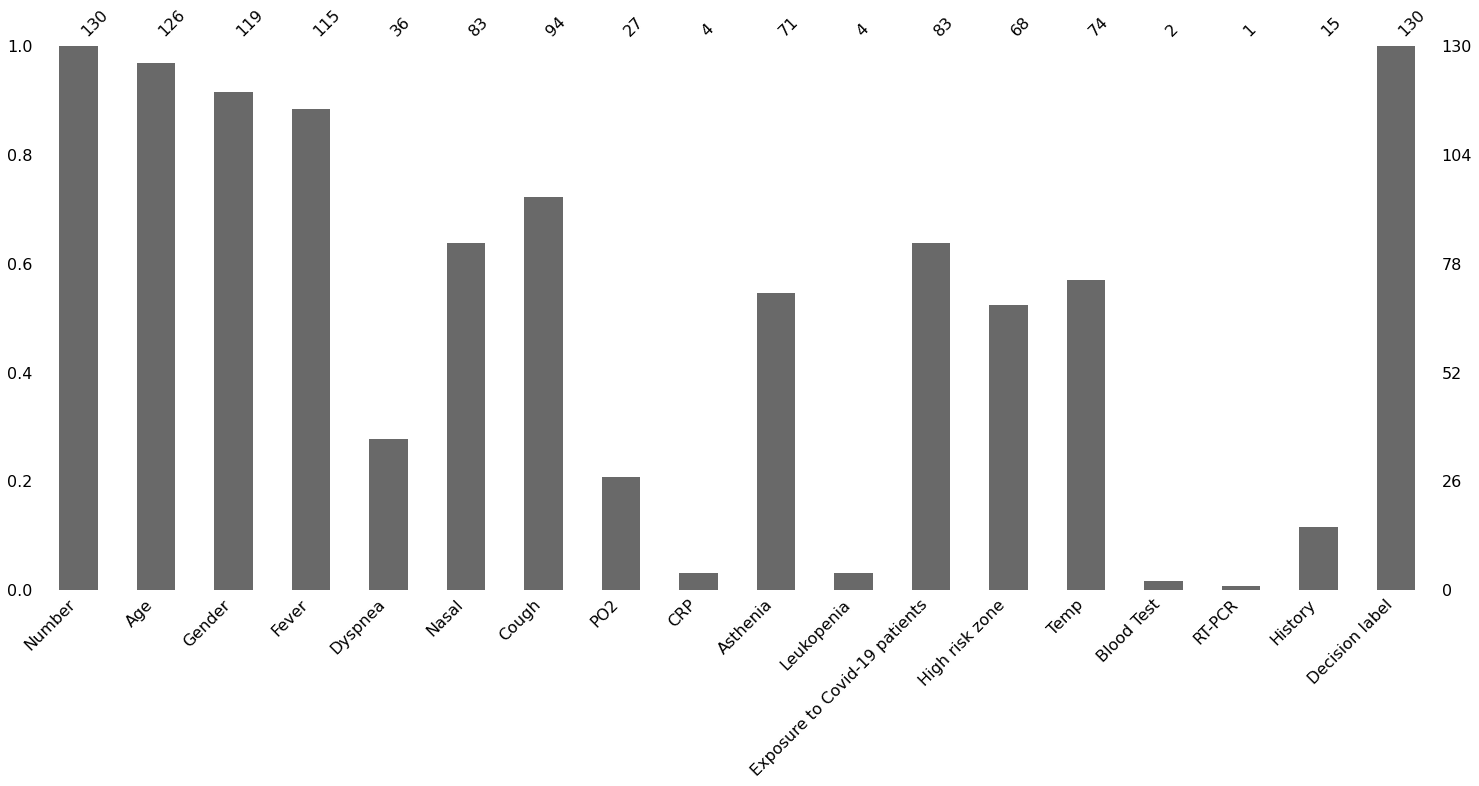

In [ ]:
# Bar chart of the number of values each feature has.
msno.bar(data)

In [ ]:
# Split the data.
X = data.drop(['Number', 'Decision label'], axis=1)
y = data['Decision label']

In [ ]:
# Show the percentage of missing vlaues for each variable.
data.isna().mean().round(4) * 100

Number                            0.00
Age                               3.08
Gender                            8.46
Fever                            11.54
Dyspnea                          72.31
Nasal                            36.15
Cough                            27.69
PO2                              79.23
CRP                              96.92
Asthenia                         45.38
Leukopenia                       96.92
Exposure to Covid-19 patients    36.15
High risk zone                   47.69
Temp                             43.08
Blood Test                       98.46
RT-PCR                           99.23
History                          88.46
Decision label                    0.00
dtype: float64

In [ ]:
# Drop features with more than 50% of missing values.
count = 0
for column in X.columns:
  if(X[column].isna().mean().round(4) * 100 > 50.00):
    count += 1
    X.drop(column, axis=1, inplace=True)

print('The number of features with 50% or more missing values is: ', count)

The number of features with 50% or more missing values is:  7


In [ ]:
# Show the percentage of missing vlaues for each variable after droping.
X.isna().mean().round(4) * 100

Age                               3.08
Gender                            8.46
Fever                            11.54
Nasal                            36.15
Cough                            27.69
Asthenia                         45.38
Exposure to Covid-19 patients    36.15
High risk zone                   47.69
Temp                             43.08
dtype: float64

In [ ]:
# Drop features with only 1 unique value (Zero Variance Features).
print(X.nunique())
X.drop('High risk zone', axis=1, inplace=True)
print("Shape of X: ", X.shape)

Age                              53
Gender                            2
Fever                             2
Nasal                             2
Cough                             2
Asthenia                          2
Exposure to Covid-19 patients     3
High risk zone                    1
Temp                             30
dtype: int64
Shape of X:  (130, 8)


---------------------------

In [ ]:
# Identify categorical features and numeric features in seprate lists then combine them in one list.
categorical_features = ['Gender', 'Fever', 'Nasal', 'Cough', 'Asthenia', 'Exposure to Covid-19 patients']

numerical_features = []
counter = 0
for column in X:
  counter = 0
  for i in range(len(categorical_features)):
    if column == categorical_features[i]:
      counter = 1

  if counter == 0:
    numerical_features.append(column)

cat_num_features = []
for i in range(len(categorical_features)):
  cat_num_features.append(categorical_features[i])

for i in range(len(numerical_features)):
  cat_num_features.append(numerical_features[i])

# Verify both has same number of features.
print("Shape of X:", X.shape)
print("Number of Categorical Features =", len(categorical_features))
print("Number of Numerical Features =", len(numerical_features))

Shape of X: (130, 8)
Number of Categorical Features = 6
Number of Numerical Features = 2


In [ ]:
# Impute missing vlaues. [SIMPLE IMPUTER]
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

imputer = ColumnTransformer([("cat_imputer", cat_imputer, categorical_features), 
                             ("num_imputer", num_imputer, numerical_features)])
filled_X = imputer.fit_transform(X)

X = pd.DataFrame(filled_X, columns=cat_num_features)

In [ ]:
X.loc[X['Exposure to Covid-19 patients'] == "No ", 'Exposure to Covid-19 patients'] = "No" # one value has a space.

dummies = pd.get_dummies(X[categorical_features], drop_first=True)

X.drop(categorical_features, axis=1, inplace=True)
X = X.join(dummies)

In [ ]:
feature_names = []
for column in X.columns:
  feature_names.append(column)

In [ ]:
# Impute missing vlaues. [KNN IMPUTER]
imputer = KNNImputer(n_neighbors=11)
filled_X = imputer.fit_transform(X)
X = pd.DataFrame(filled_X, columns=feature_names) 

In [ ]:
# Standraize features.
standardize_scaler = StandardScaler()

standardizedX = standardize_scaler.fit(X).transform(X)
X = pd.DataFrame(standardizedX, columns=feature_names)

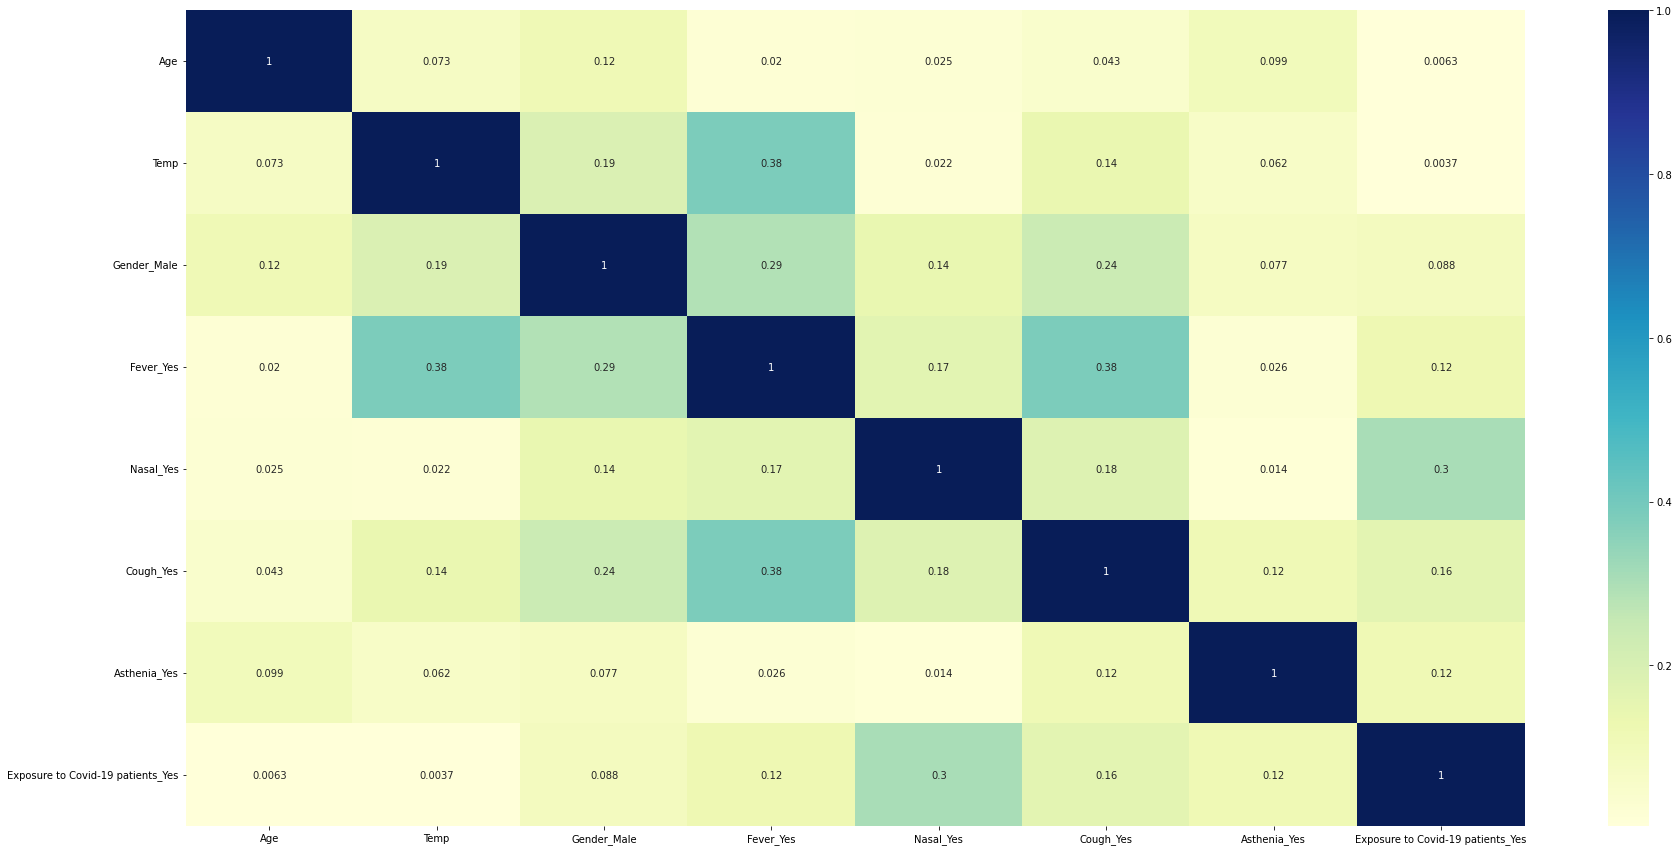

In [ ]:
# correlation matrix to see if there are features with high correlation.
plt.figure(figsize = (30,15))
corr = X.corr().abs()
hm = sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
print("Shape of the dataset [before] preprocessing: (130, 18)")
print("Shape of the dataset [after] preprocessing: (130, 9)")

Shape of the dataset [before] preprocessing: (130, 18)
Shape of the dataset [after] preprocessing: (130, 9)


## **#4 Model**

In [ ]:
# Target variable class distribution.
print(pd.DataFrame(y).groupby('Decision label').size())

Decision label
0    62
1    68
dtype: int64


In [ ]:
# List of all 7 classifiers.
model_list = [LogisticRegression(random_state=111), svm.SVC(random_state=111), KNeighborsClassifier(n_neighbors=7), 
              GaussianNB(), DecisionTreeClassifier(random_state=111), RandomForestClassifier(random_state=111), 
              xgb.XGBClassifier(random_state=111)]

model_names_list = ['LR', 'SVM', 'KNN', 'NB', 'DT', 'RF', 'XGB']

In [ ]:
# Models evaluation using 5-fold cross validation.
cross_validator = ShuffleSplit(n_splits=5, random_state=111)

y=y.astype('int')
score_f1_list = []
score_recall_list = []
score_precision_list = []
for m in range(len(model_list)):
    model = model_list[m]
    
    score_f1 = cross_val_score(model, X, y, scoring='f1_macro', cv=cross_validator).mean().round(2) * 100
    score_f1_list.append(score_f1)
    print("The [F1-Score] using {} classifier, is: {}".format(model_names_list[m], score_f1))

    score_recall = cross_val_score(model, X, y, scoring='recall_macro', cv=cross_validator).mean().round(2) * 100
    score_recall_list.append(score_recall)
    print("The [Recall] using {} classifier, is: {}".format(model_names_list[m], score_recall))

    score_precision = cross_val_score(model, X, y, scoring='precision_macro', cv=cross_validator).mean().round(2) * 100
    score_precision_list.append(score_precision)
    print("The [Precision] using {} classifier, is: {}".format(model_names_list[m], score_precision))
    print()

The [F1-Score] using LR classifier, is: 74.0
The [Recall] using LR classifier, is: 75.0
The [Precision] using LR classifier, is: 75.0

The [F1-Score] using SVM classifier, is: 77.0
The [Recall] using SVM classifier, is: 80.0
The [Precision] using SVM classifier, is: 80.0

The [F1-Score] using KNN classifier, is: 71.0
The [Recall] using KNN classifier, is: 73.0
The [Precision] using KNN classifier, is: 74.0

The [F1-Score] using NB classifier, is: 46.0
The [Recall] using NB classifier, is: 57.99999999999999
The [Precision] using NB classifier, is: 56.00000000000001

The [F1-Score] using DT classifier, is: 74.0
The [Recall] using DT classifier, is: 75.0
The [Precision] using DT classifier, is: 73.0

The [F1-Score] using RF classifier, is: 81.0
The [Recall] using RF classifier, is: 82.0
The [Precision] using RF classifier, is: 83.0

The [F1-Score] using XGB classifier, is: 74.0
The [Recall] using XGB classifier, is: 74.0
The [Precision] using XGB classifier, is: 74.0



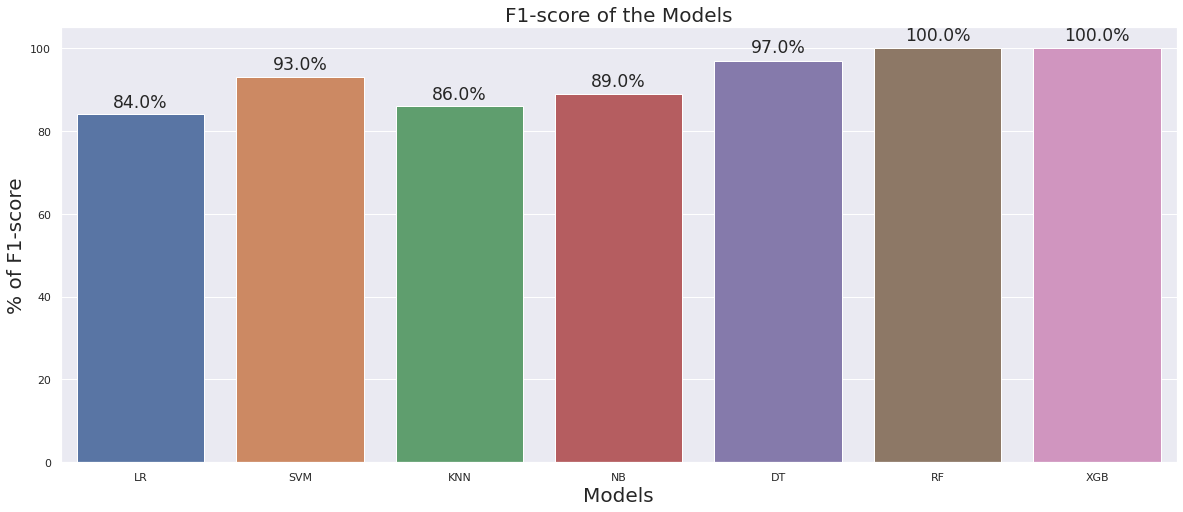

In [ ]:
# Results visualization. [F1-score]
ax = sns.barplot(x=model_names_list, y=score_f1_list) 
plt.xlabel('Models', fontsize = 20)
plt.ylabel('% of F1-score', fontsize = 20)
plt.title('F1-score of the Models', fontsize = 20)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    xs, ys = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (xs + width/2, ys + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

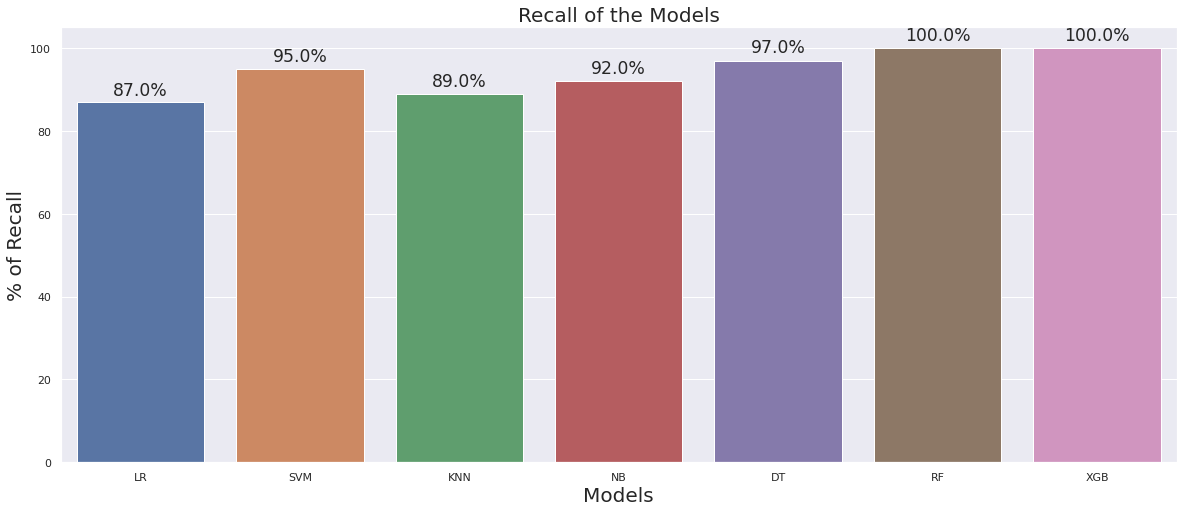

In [ ]:
# Results visualization. [Recall]
ax = sns.barplot(x=model_names_list, y=score_recall_list) 
plt.xlabel('Models', fontsize = 20)
plt.ylabel('% of Recall', fontsize = 20)
plt.title('Recall of the Models', fontsize = 20)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    xs, ys = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (xs + width/2, ys + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

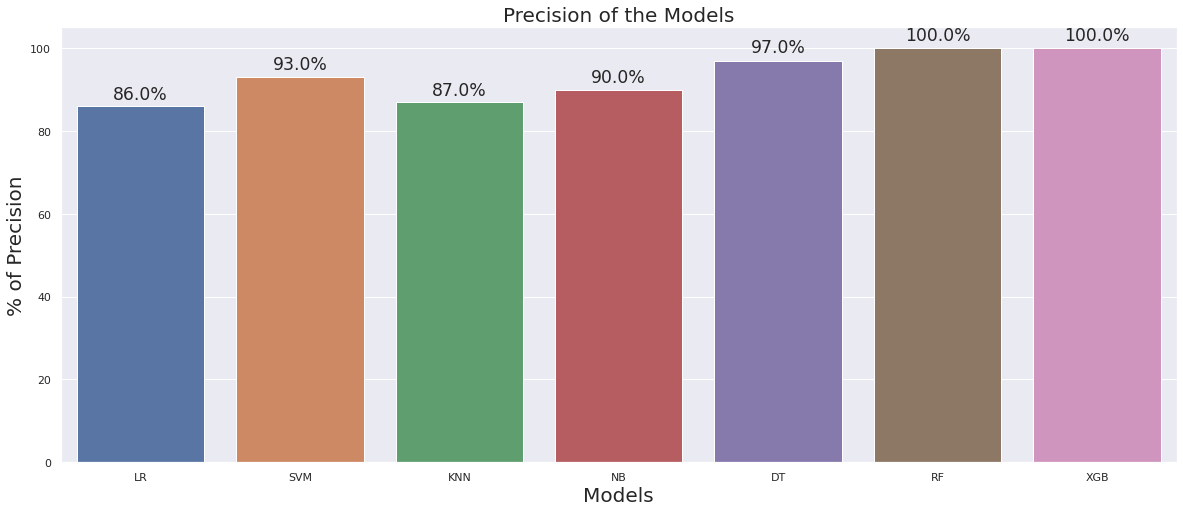

In [ ]:
# Results visualization. [Precision]
ax = sns.barplot(x=model_names_list, y=score_precision_list)
plt.xlabel('Models', fontsize = 20)
plt.ylabel('% of Precision', fontsize = 20)
plt.title('Precision of the Models', fontsize = 20)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    xs, ys = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (xs + width/2, ys + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

## **#5 Feature Importance**

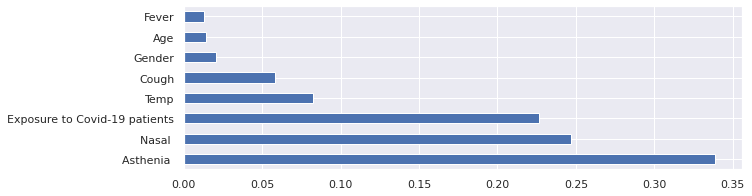

In [ ]:
# Feature importance using RF.
model = RandomForestClassifier(random_state=111)
model.fit(X, y)

features_importance = pd.Series(model.feature_importances_, index=X.columns)

# Show feature importance scores.
features_importance.nlargest(8).plot(figsize=(10, 3), kind='barh')
plt.show()